In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import config
import utility.df
import utility.iolib
import utility.plotlib
import model.performance

from utility.feature import Feature
from utility.feature import FeatureCM
from model.dataEngine import DataEngine

#env = sys.argv[1] if len(sys.argv) > 2 else "dev"

## Configuration and Data Loading

In [2]:
# Setup configuration
cfg = config.ResearchConfig
time_format = cfg.CSV_TIME_FORMAT
date_format = cfg.CSV_DATE_FORMAT
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)

# Retrieve data
df_subspt, df_lesson, df_incomp, df_crclum, df_pupils = utility.iolib.retrieve_data(cfg)
print("Complete loading data for subscription and lesson history!")

# Filter data
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)
first_date_impFromData = df_subspt.subscription_start_date.min()

pupils_toBeRemoved = utility.df.filter_subspt_data(
    df_subspt, first_date_impFromData, cutoff_date, remove_annual_subspt=cfg.MONTHLY_ONLY)
df_lesson1 = df_lesson[~df_lesson['pupilId'].isin(pupils_toBeRemoved)]
df_incomp1 = df_incomp[~df_incomp['pupilId'].isin(pupils_toBeRemoved)]
df_subspt1 = df_subspt[~df_subspt['pupilId'].isin(pupils_toBeRemoved)]

df_subspt1 = utility.df.compute_customer_month(df_subspt1, cfg)

# Construct dates frame
df_datesFrame = utility.df.construct_dates_frame(df_subspt1, df_lesson1, df_incomp1, cfg)
df_datesFrame.fillna(0, inplace=True)

Complete loading data for subscription and lesson history!
By the cutoff date 2018-04-20, there are 1234 active subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to know the lifetime of their subscriptions. 

In the first month of dataset starting from 2014-01-01, there are 154 renewal or new subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to show if they renewed or newly joined. 

We also choose to remove 2525 annual subscribers. 

In summary, there are 3013/5685 subscribers being removed from the dataset in the analysis. 

Calculate customer month in the subscription table.


100%|██████████| 2672/2672 [00:03<00:00, 871.27it/s] 


Construct data-driven dates frame.
The dates frame has already been assigned customer month and saved in a file. The file has been loaded!


## Features Preparation

In [3]:
data_engine = DataEngine(df_subspt1, df_datesFrame, df_lesson1, df_incomp1, df_pupils, cfg)
data_engine.aggregate_features()

ftr_list = ['usage', 'usage_complete', 'usage_incomplete', 'rate_incomplete_usage',
            'last_access', 
            'age', 'math_age',
            'rate_assess', 'sum_help', 
            'progress', 'progress_delta',
            'num_attempt',  'num_complete', 'num_incomplete', 'rate_incomplete_num', 
            'num_pass', 'num_replay', 'num_fail',
            'holiday',
            'age_diff'
           ]
ftr_list = ['usage_complete', 'usage_incomplete', 'usage',
            'last_access', 
            'math_age', 'age',
            'rate_assess', 'sum_help', 
            'progress', 'progress_delta',
            'num_complete',  'num_incomplete', 'num_attempt', 
            'num_pass', 'num_replay', 'num_fail',
            'age_diff'
           ]

data_engine.select_features(ftr_list)
data_engine.transform_boxCox()

X = data_engine.data_
Xt = data_engine.data_bc_
y = data_engine.target_

df_whizz1 = data_engine.df_whizz_

Construct feature object.
+ Add feature: usage time.
+ Add feature: progressions.
+ Add feature: pupils' age.
+ Add feature: math age.
+ Add feature: outcome.
+ Add feature: score.
+ Add feature: hardship.
Aggregate data over customer months.


100%|██████████| 49/49 [00:09<00:00,  5.03it/s]


## Feature Distribution (Raw)

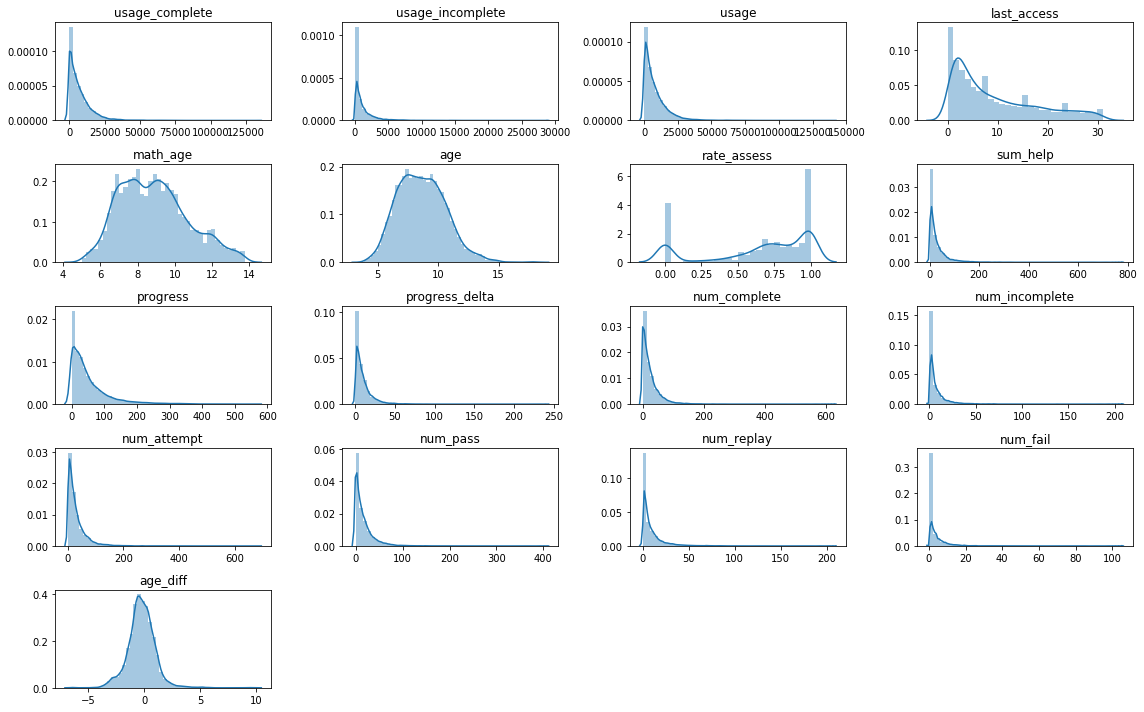

In [4]:
ftr_list_nontransform = []
utility.plotlib.feature_distribution(
    df_whizz1, ftr_list, 4, cfg, 
    transform=False, ftr_list_nontransform=ftr_list_nontransform)

## Feature Distribution (Transformed and Scaled)

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


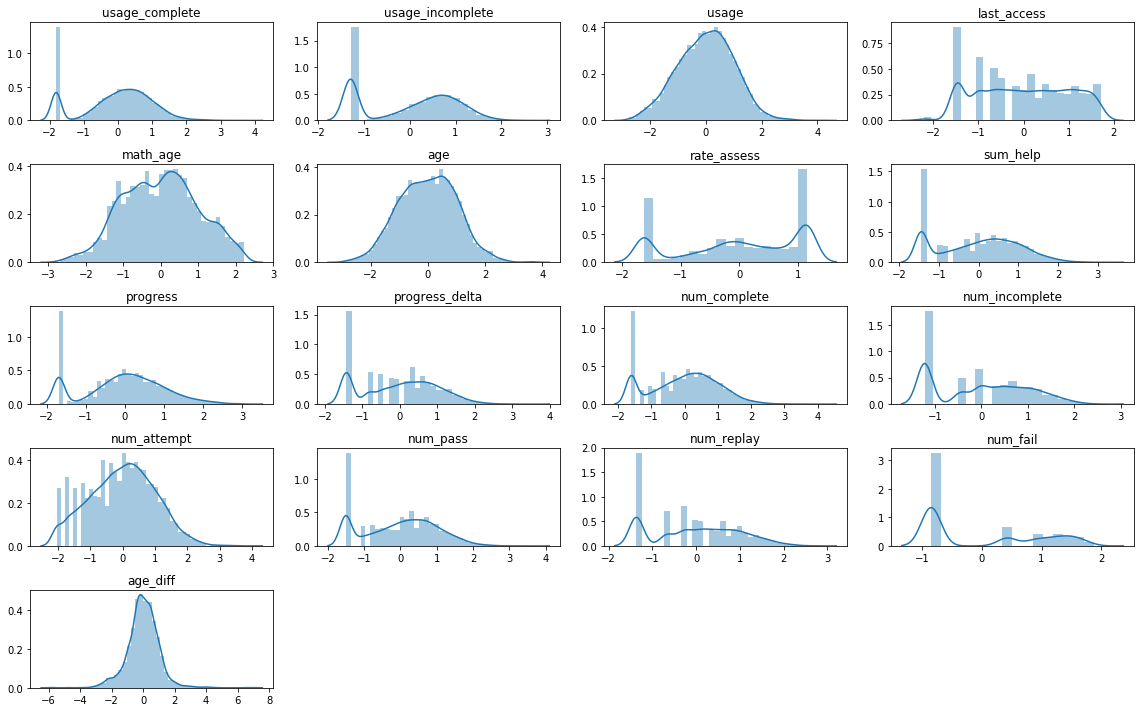

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(Xt)
Xt_scaled = scaler.transform(Xt)

scaler.fit(X)
X_scaled = scaler.transform(X)

temp = pd.DataFrame(data=Xt_scaled, columns=ftr_list)
utility.plotlib.feature_distribution(temp, ftr_list, 4, cfg, 
    transform=False, ftr_list_nontransform=ftr_list_nontransform)

In [98]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

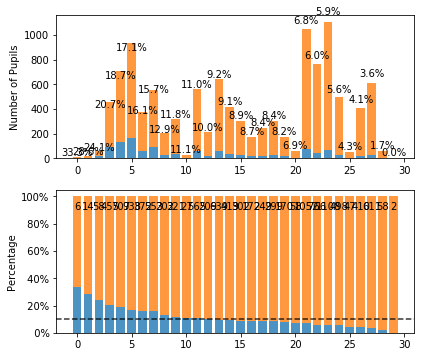

In [103]:
from sklearn.cluster import KMeans

n_components = 30
kmeans = KMeans(n_clusters=n_components, n_init=10, verbose=0).fit(X_scaled)

predictions = kmeans.predict(X_scaled)
utility.plotlib.component_bar(y, predictions, n_components)

Explained variance = 0.9804643455971469


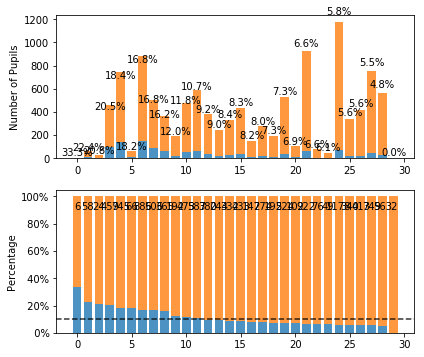

In [133]:
# apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=10) # only keep the first two principal components
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print('Explained variance = {}'.format(pca.explained_variance_ratio_.sum()))

n_components = 30
kmeans = KMeans(n_clusters=n_components, n_init=1, verbose=0).fit(X_pca)
predictions = kmeans.predict(X_pca)
utility.plotlib.component_bar(y, predictions, n_components)